İŞLEM BAŞLIYOR: GELİŞMİŞ K-MEANS ANALİZİ
'musteri.csv' başarıyla okundu!
İşlenen sütunlar: ['Annual Income (k$)', 'Spending Score (1-100)']
Veriler ölçeklendi (StandardScaler uygulandı).
🔄 En uygun küme sayısı (K) aranıyor:
   K=2 için Silhouette Skoru: 0.397
   K=3 için Silhouette Skoru: 0.467
   K=4 için Silhouette Skoru: 0.494
   K=5 için Silhouette Skoru: 0.555
   K=6 için Silhouette Skoru: 0.514
   K=7 için Silhouette Skoru: 0.502
   K=8 için Silhouette Skoru: 0.455
   K=9 için Silhouette Skoru: 0.457
   K=10 için Silhouette Skoru: 0.445
Optimizasyon grafikleri gösteriliyor.


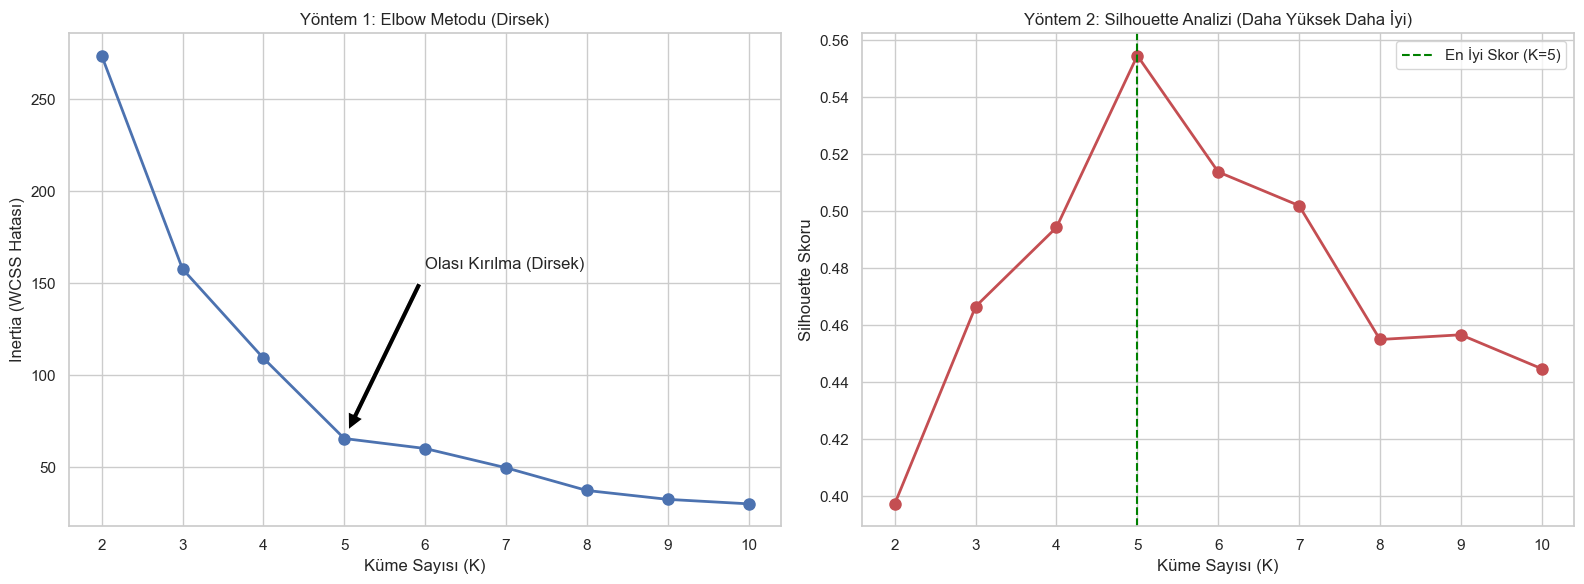


Final model K=5 ile kuruluyor.
Final kümeleme grafiği gösteriliyor.


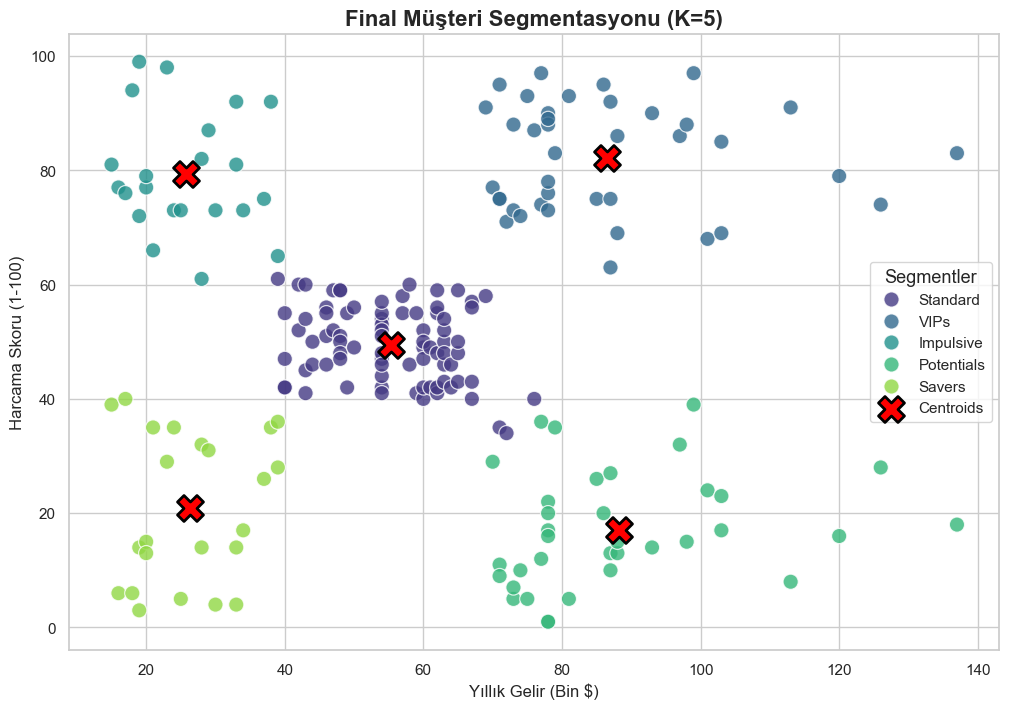


 İŞLEM TAMAM.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import os
import numpy as np

# Grafik ayarları
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

print("İŞLEM BAŞLIYOR: GELİŞMİŞ K-MEANS ANALİZİ")

dosya_adi = 'musteri.csv'


# VERİYİ OKUMA VE HAZIRLAMA

try:
    # Dosya okuma (with debugging)
    try:
        df = pd.read_csv(dosya_adi)
    except:
        df = pd.read_csv(dosya_adi, sep=';')

    print(f"'{dosya_adi}' başarıyla okundu!")

    # Sütun seçimi (Gelir ve Skor)
    try:
        # Sütun isimleri farklıysa
        cols_to_use = ['Annual Income (k$)', 'Spending Score (1-100)']
        X_original = df[cols_to_use].values
        print(f"İşlenen sütunlar: {cols_to_use}")
    except KeyError:
        print("Belirtilen sütun isimleri bulunamadı, son iki sütun kullanılıyor.")
        X_original = df.iloc[:, -2:].values

    # VERİ ÖLÇEKLEME (Scaling) 
    # K-Means mesafe tabanlıdır. Yani gelir ve skoru aynı ölçeğe (Standard Normal Dağılım) getirmemiz lazım.
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_original)
    print("Veriler ölçeklendi (StandardScaler uygulandı).")


    
    # EN UYGUN KÜME SAYISINI (K) BULMA (Optimizasyon)
    
    print("🔄 En uygun küme sayısı (K) aranıyor:")

    inertia = [] 
    silhouette_scores = [] 
    K_range = range(2, 11) 

    for k in K_range:
        # Modeli kurmak
        kmeans_temp = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init='auto')
        kmeans_temp.fit(X_scaled)

        # Skorları kaydetmek
        inertia.append(kmeans_temp.inertia_)
        score = silhouette_score(X_scaled, kmeans_temp.labels_)
        silhouette_scores.append(score)
        print(f"   K={k} için Silhouette Skoru: {score:.3f}")

    # OPTİMİZASYON GRAFİKLERİ 
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Grafik 1: Elbow Yöntemi (Dirsek)
    ax1.plot(K_range, inertia, 'bo-', linewidth=2, markersize=8)
    ax1.set_title('Yöntem 1: Elbow Metodu (Dirsek)')
    ax1.set_xlabel('Küme Sayısı (K)')
    ax1.set_ylabel('Inertia (WCSS Hatası)')
    ax1.annotate('Olası Kırılma (Dirsek)', xy=(5, inertia[3]), xytext=(6, inertia[1]),
                 arrowprops=dict(facecolor='black', shrink=0.05),)

    # Grafik 2: Silhouette Skorları
    ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    ax2.set_title('Yöntem 2: Silhouette Analizi (Daha Yüksek Daha İyi)')
    ax2.set_xlabel('Küme Sayısı (K)')
    ax2.set_ylabel('Silhouette Skoru')
    best_k_sil = K_range[np.argmax(silhouette_scores)]
    ax2.axvline(x=best_k_sil, color='green', linestyle='--', label=f'En İyi Skor (K={best_k_sil})')
    ax2.legend()

    plt.tight_layout()
    print("Optimizasyon grafikleri gösteriliyor.")
    plt.show()

    
    # FİNAL MODELİ KURMA (K=5 Varsayımıyla)
    
    # Not: K=5, bu veri seti için en iyisidir genelde.
    FINAL_K = 5
    print(f"\nFinal model K={FINAL_K} ile kuruluyor.")

    kmeans_final = KMeans(n_clusters=FINAL_K, init='k-means++', random_state=42, n_init='auto')
    y_kmeans_final = kmeans_final.fit_predict(X_scaled)

    # Merkez noktalarını orijinal ölçeğe geri döndür (Grafikte doğru yerde görmek için)
    centroids_original = scaler.inverse_transform(kmeans_final.cluster_centers_)


    
    # FİNAL GÖRSELLEŞTİRME (Seaborn)
    
    # Çizim için geçici bir DataFrame oluşturmamız lazım.
    df_plot = pd.DataFrame(X_original, columns=['Yıllık Gelir', 'Harcama Skoru'])
    df_plot['Küme'] = y_kmeans_final
    # Kategorik olarak işaretliyoruz
    df_plot['Küme'] = df_plot['Küme'].astype('category')
    df_plot['Küme Ismi'] = df_plot['Küme'].map({0:'Standard', 1:'VIPs', 2:'Impulsive', 3:'Potentials', 4:'Savers'})


    plt.figure(figsize=(12, 8))

    # SEABORN İLE DAHA İYİ GÖRSELLEŞTİRME
    # Ana grafik
    sns.scatterplot(data=df_plot, x='Yıllık Gelir', y='Harcama Skoru',
                    hue='Küme Ismi', palette='viridis', s=120, alpha=0.8, edgecolor='w')

    # Merkezleri ekliyoruz.
    plt.scatter(centroids_original[:, 0], centroids_original[:, 1],
                s=350, c='red', marker='X', label='Centroids', edgecolors='black', linewidth=2)

    plt.title(f'Final Müşteri Segmentasyonu (K={FINAL_K})', fontsize=16, fontweight='bold')
    plt.xlabel('Yıllık Gelir (Bin $)', fontsize=12)
    plt.ylabel('Harcama Skoru (1-100)', fontsize=12)
    plt.legend(title='Segmentler', title_fontsize='13', fontsize='11')

    print("Final kümeleme grafiği gösteriliyor.")
    plt.show()

except FileNotFoundError:
    print(f"\nHATA: '{dosya_adi}' dosyası bulunamadı!")
    print("Lütfen CSV dosyasının bu kod ile aynı klasörde olduğundan emin olun.")
except Exception as e:
    print(f"\nBeklenmedik bir hata oluştu:\n{e}")
finally:
    print("\n İŞLEM TAMAM.")

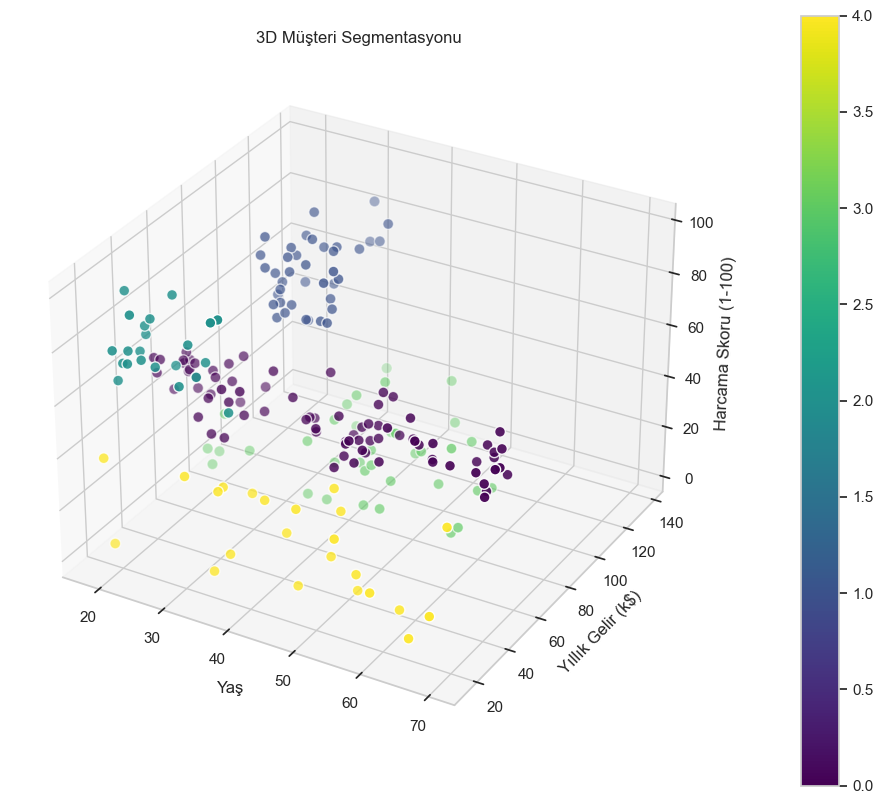

In [9]:

from mpl_toolkits.mplot3d import Axes3D

# 3D Grafik
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# X, Y Z eksenleri 
# df sütun isimleri: 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'

x_axis = df['Age']
y_axis = df['Annual Income (k$)']
z_axis = df['Spending Score (1-100)']

scatter = ax.scatter(x_axis, y_axis, z_axis, c=y_kmeans_final, s=60, cmap='viridis', edgecolors='w')

# Eksen etiketleri
ax.set_xlabel('Yaş')
ax.set_ylabel('Yıllık Gelir (k$)')
ax.set_zlabel('Harcama Skoru (1-100)')
ax.set_title('3D Müşteri Segmentasyonu')

# Renk barı
plt.colorbar(scatter, pad=0.1)
plt.show()


--- EK ANALİZLER ---


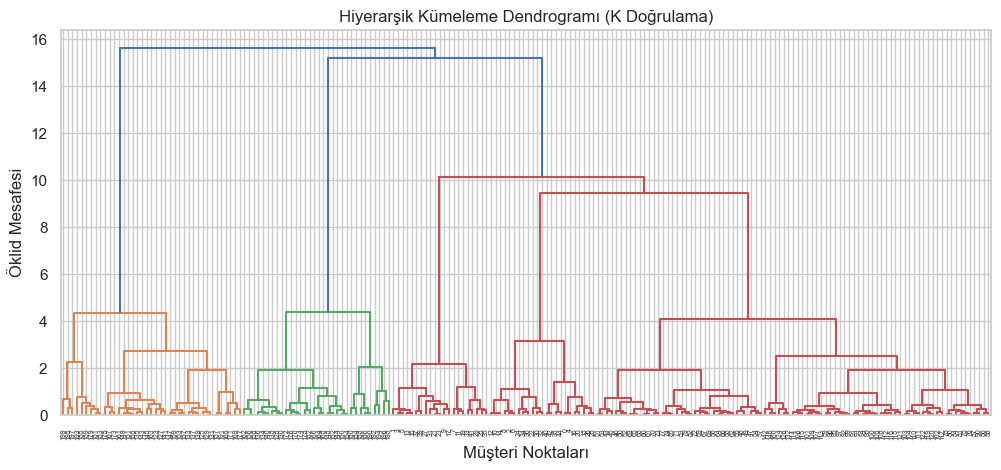


KÜME PROFİLLERİ (Ortalama Gelir ve Skor):
   Kume_No      Gelir       Skor
0        0  55.296296  49.518519
1        1  86.538462  82.128205
2        2  25.727273  79.363636
3        3  88.200000  17.114286
4        4  26.304348  20.913043

DİKKAT: Gruba En Az Uyan (Aykırı) 5 Müşteri:
     Gelir  Skor  Kume_No  Merkeze_Uzaklik
199    137    83        1         1.926385
198    137    18        3         1.862985
197    126    74        1         1.538923
196    126    28        3         1.503421
195    120    79        1         1.282968


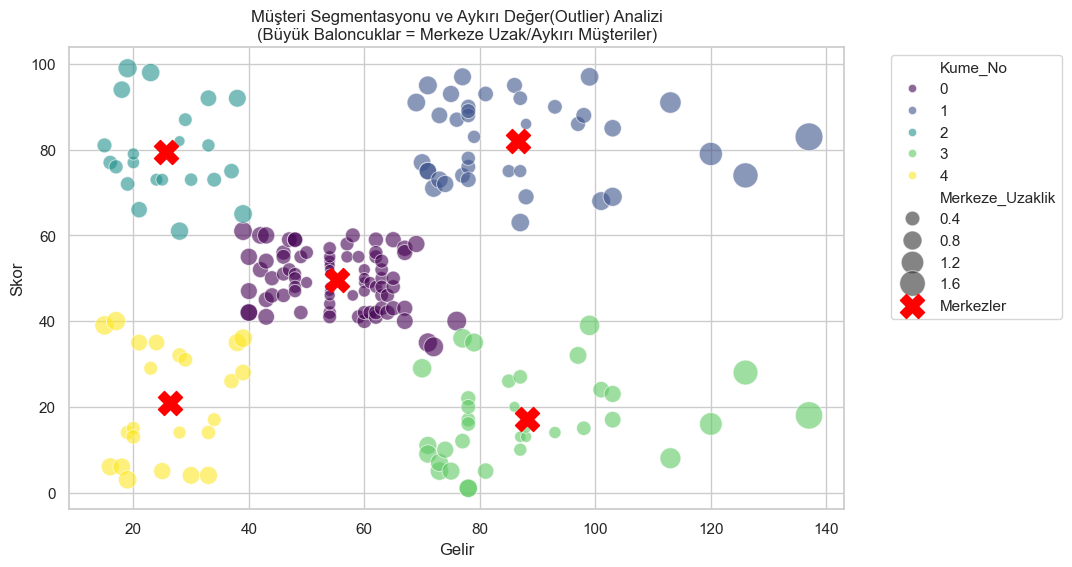

In [10]:
import scipy.cluster.hierarchy as sch # Hiyerarşik kümeleme

print("\n--- EK ANALİZLER ---")

# 1. HİYERARŞİK KÜMELEME (DENDROGRAM)

# Bu grafik, K-Means'teki "K=5"in sağlamasını yapar.
plt.figure(figsize=(12, 5))
plt.title("Hiyerarşik Kümeleme Dendrogramı (K Doğrulama)")

# Ward yöntemi
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'))
plt.xlabel('Müşteri Noktaları')
plt.ylabel('Öklid Mesafesi')
plt.show()

# 2. MATEMATİKSEL MERKEZ ANALİZİ (Centroid Interpretation)

# Her grubun 'Ortalama Karakterini' çıkartmak:
df_analiz = pd.DataFrame(X_original, columns=['Gelir', 'Skor'])
df_analiz['Kume_No'] = y_kmeans_final 


profil_tablosu = df_analiz.groupby('Kume_No').mean().reset_index()
print("\nKÜME PROFİLLERİ (Ortalama Gelir ve Skor):")
print(profil_tablosu)

# 3. ÖKLİD MESAFESİ İLE "SADAKAT" VE "ANOMALİ" ANALİZİ

tum_uzakliklar = kmeans_final.transform(X_scaled)

df_analiz['Merkeze_Uzaklik'] = np.min(tum_uzakliklar, axis=1)

# En Aykırı 5 Müşteri (Outliers): Merkeze en uzaktakiler
aykirilar = df_analiz.sort_values('Merkeze_Uzaklik', ascending=False).head(5)

print("\nDİKKAT: Gruba En Az Uyan (Aykırı) 5 Müşteri:")
print(aykirilar)

# 4. GÖRSELLEŞTİRME (Baloncuk Grafiği)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_analiz, x='Gelir', y='Skor', hue='Kume_No',
                palette='viridis', size='Merkeze_Uzaklik', sizes=(50, 400), alpha=0.6)

# Gerçek merkezler (Kırmızı X işaretleri)
plt.scatter(centroids_original[:, 0], centroids_original[:, 1],
            s=300, c='red', marker='X', label='Merkezler')

plt.title('Müşteri Segmentasyonu ve Aykırı Değer(Outlier) Analizi\n(Büyük Baloncuklar = Merkeze Uzak/Aykırı Müşteriler)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

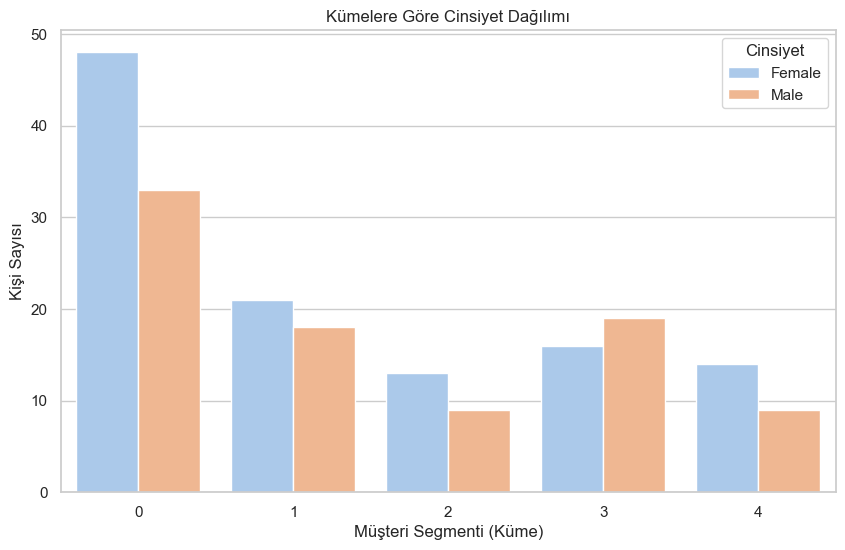

In [11]:
# EK GÖRSEL 1: CİNSİYET ANALİZİ

df['Kume_No'] = y_kmeans_final

plt.figure(figsize=(10, 6))
sns.countplot(x='Kume_No', hue='Gender', data=df, palette='pastel')
plt.title('Kümelere Göre Cinsiyet Dağılımı')
plt.xlabel('Müşteri Segmenti (Küme)')
plt.ylabel('Kişi Sayısı')
plt.legend(title='Cinsiyet')
plt.show()

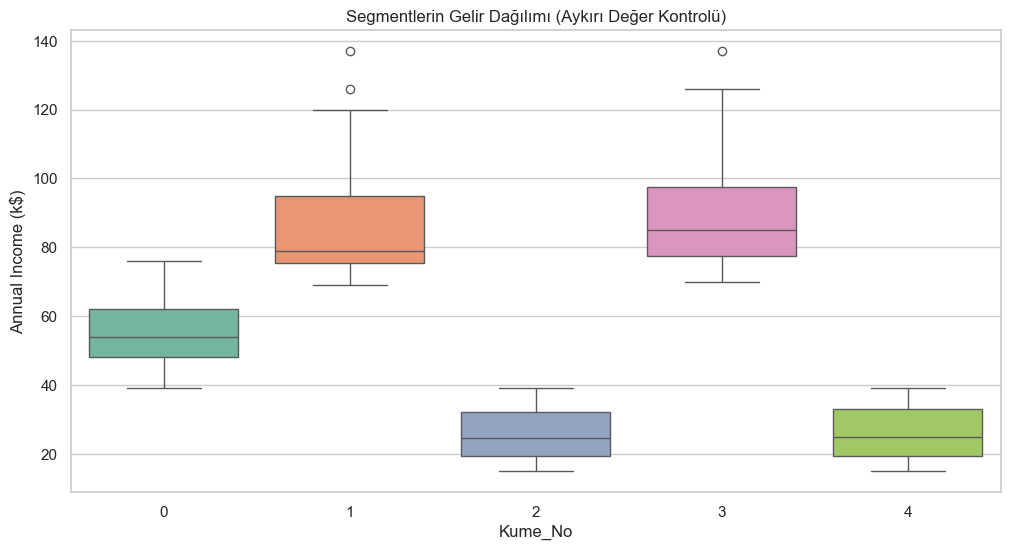

In [12]:

plt.figure(figsize=(12, 6))

sns.boxplot(x='Kume_No', y='Annual Income (k$)', data=df, hue='Kume_No', palette='Set2', legend=False)

plt.title('Segmentlerin Gelir Dağılımı (Aykırı Değer Kontrolü)')
plt.show()

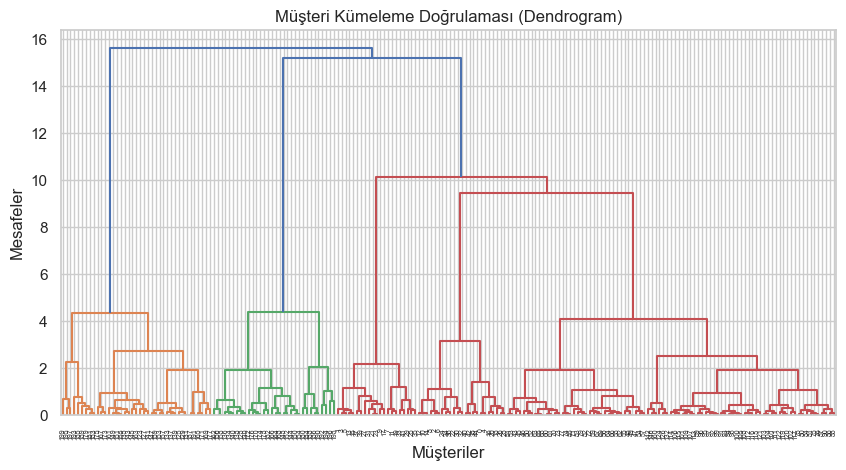

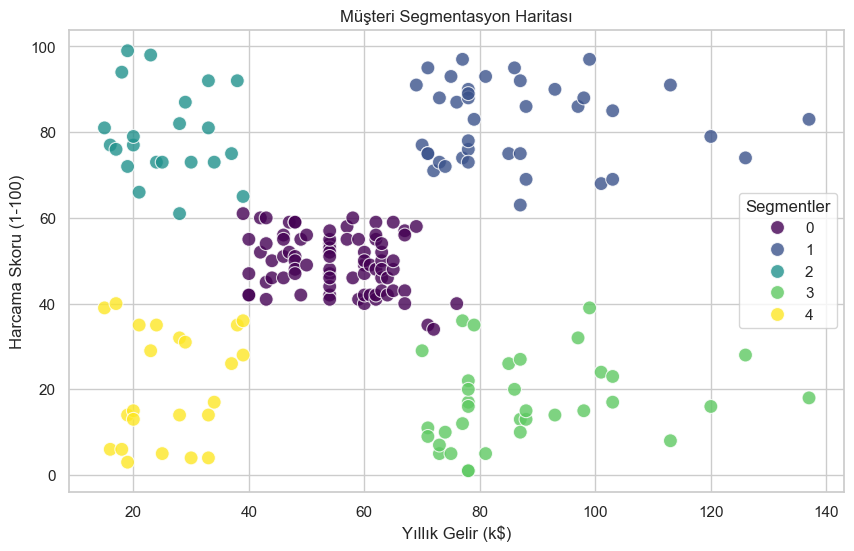

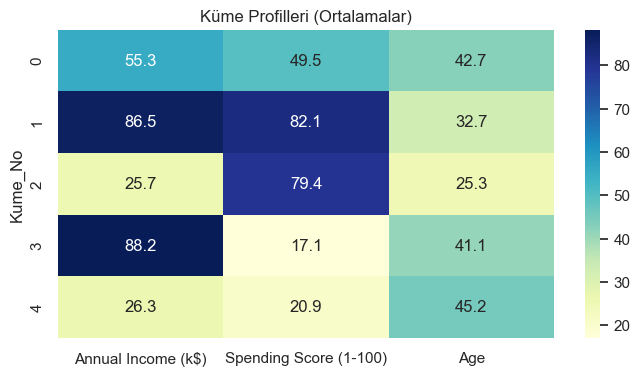

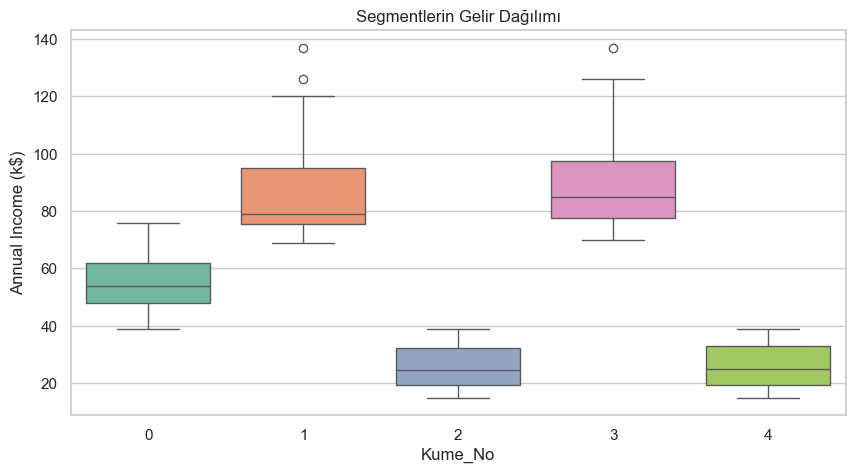

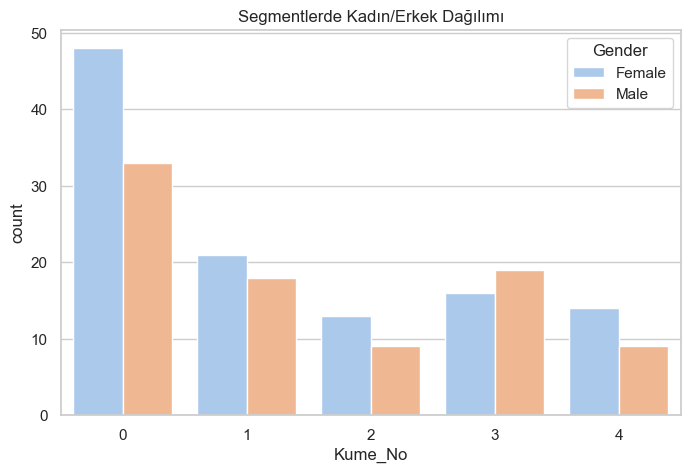

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Ayarlar
sns.set_theme(style="whitegrid")
dosya_adi = 'musteri.csv'

# Veriyi Hazırla
df = pd.read_csv(dosya_adi)
if 'Annual Income (k$)' in df.columns:
    X_original = df[['Annual Income (k$)', 'Spending Score (1-100)']].values
else:
    X_original = df.iloc[:, -2:].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)

# K-Means Modelini kurarız
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init='auto')
y_kmeans = kmeans.fit_predict(X_scaled)
df['Kume_No'] = y_kmeans

#  GRAFİK 1: METODOLOJİ (DENDROGRAM) 
plt.figure(figsize=(10, 5))
plt.title("Müşteri Kümeleme Doğrulaması (Dendrogram)")
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'))
plt.xlabel('Müşteriler')
plt.ylabel('Mesafeler')
plt.savefig('Slayt_3_Metodoloji.png', dpi=300) 
plt.show()

#  GRAFİK 2: ANA ANALİZ (SCATTER PLOT) 
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_original[:,0], y=X_original[:,1], hue=y_kmeans,
                palette='viridis', s=100, alpha=0.8)
plt.title('Müşteri Segmentasyon Haritası')
plt.xlabel('Yıllık Gelir (k$)')
plt.ylabel('Harcama Skoru (1-100)')
plt.legend(title='Segmentler')
plt.savefig('Slayt_4_Segment_Haritasi.png', dpi=300)
plt.show()

#  GRAFİK 3: PERSONA ANALİZİ (HEATMAP) 
plt.figure(figsize=(8, 4))
ozet = df[['Annual Income (k$)', 'Spending Score (1-100)', 'Age', 'Kume_No']].groupby('Kume_No').mean()
sns.heatmap(ozet, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Küme Profilleri (Ortalamalar)")
plt.savefig('Slayt_5_Personalar.png', dpi=300)
plt.show()

#  GRAFİK 4: NETLİK KANITI (BOX PLOT)
plt.figure(figsize=(10, 5))
sns.boxplot(x='Kume_No', y='Annual Income (k$)', data=df, hue='Kume_No', palette='Set2', legend=False)
plt.title('Segmentlerin Gelir Dağılımı')
plt.savefig('Slayt_5_Ek_Gelir_Analizi.png', dpi=300)
plt.show()

#  GRAFİK 5: HEDEF KİTLE (CİNSİYET)
plt.figure(figsize=(8, 5))
sns.countplot(x='Kume_No', hue='Gender', data=df, palette='pastel')
plt.title('Segmentlerde Kadın/Erkek Dağılımı')
plt.savefig('Slayt_6_Hedef_Kitle.png', dpi=300)
plt.show()